# CONFLUENCE Tutorial: Distributed Basin Workflow with Delineation

This notebook demonstrates the distributed modeling approach using the delineation method. We'll use the same Bow River at Banff location but create a distributed model with multiple GRUs (Grouped Response Units).

## Key Differences from Lumped Model

- **Domain Method**: `delineate` instead of `lumped`
- **Stream Threshold**: 5000 (creates more sub-basins)
- **Multiple GRUs**: Each sub-basin becomes a GRU
- **Routing**: mizuRoute connects the GRUs

## Learning Objectives

1. Understand watershed delineation with stream networks
2. Create a distributed model with multiple GRUs
3. Compare with lumped approach from Tutorial 1

## 1. Setup and Import Libraries

In [1]:
# Import required libraries
import sys
import os
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime
import numpy as np

# Add CONFLUENCE to path
confluence_path = Path('../').resolve()
sys.path.append(str(confluence_path))

# Import CONFLUENCE
from CONFLUENCE import CONFLUENCE

# Set up plotting style
plt.style.use('default')
%matplotlib inline

## 2. Create Configuration for Distributed Model

We'll modify the configuration from Tutorial 1 to create a distributed model.

In [2]:
# Load the template configuration
config_template_path = confluence_path / '0_config_files' / 'config_template.yaml'
with open(config_template_path, 'r') as f:
    config = yaml.safe_load(f)

# Modify for distributed delineation
config['DOMAIN_NAME'] = 'Bow_at_Banff_distributed'
config['EXPERIMENT_ID'] = 'distributed_tutorial'
config['DOMAIN_DEFINITION_METHOD'] = 'delineate'  # Changed from 'lumped'
config['STREAM_THRESHOLD'] = 5000  # Higher threshold for fewer sub-basins
config['DOMAIN_DISCRETIZATION'] = 'GRUs'  # Keep as GRUs
config['SPATIAL_MODE'] = 'Distributed'  # Changed from 'Lumped'

# Use just one parallel process for this tutorial
config['MPI_PROCESSES'] = 1

# Save the modified configuration
distributed_config_path = Path('./bow_distributed_config.yaml')
with open(distributed_config_path, 'w') as f:
    yaml.dump(config, f, default_flow_style=False)

print("=== Modified Configuration for Distributed Model ===")
print(f"Domain Name: {config['DOMAIN_NAME']}")
print(f"Domain Method: {config['DOMAIN_DEFINITION_METHOD']}")
print(f"Stream Threshold: {config['STREAM_THRESHOLD']}")
print(f"Spatial Mode: {config['SPATIAL_MODE']}")
print(f"\nConfiguration saved to: {distributed_config_path}")

=== Modified Configuration for Distributed Model ===
Domain Name: Bow_at_Banff_distributed
Domain Method: delineate
Stream Threshold: 5000
Spatial Mode: Distributed

Configuration saved to: bow_distributed_config.yaml


## 3. Initialize CONFLUENCE with Distributed Configuration

In [3]:
# Initialize CONFLUENCE with distributed configuration
confluence = CONFLUENCE(distributed_config_path)

print("=== CONFLUENCE Initialized for Distributed Model ===")
print(f"Project Directory: {confluence.project_dir}")
print(f"Data Directory: {confluence.data_dir}")

2025-05-10 17:14:12,789 - confluence_general - INFO - Initializing VariableHandler for dataset: ERA5 and model: SUMMA


=== CONFLUENCE Initialized for Distributed Model ===
Project Directory: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed
Data Directory: /work/comphyd_lab/data/CONFLUENCE_data


## 4. Visualize Lumped vs Distributed Concept

/tmp/ipykernel_283846/3544850342.py:21: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(pos, 0.15, fill=True, color=color, alpha=0.7, edgecolor='black')


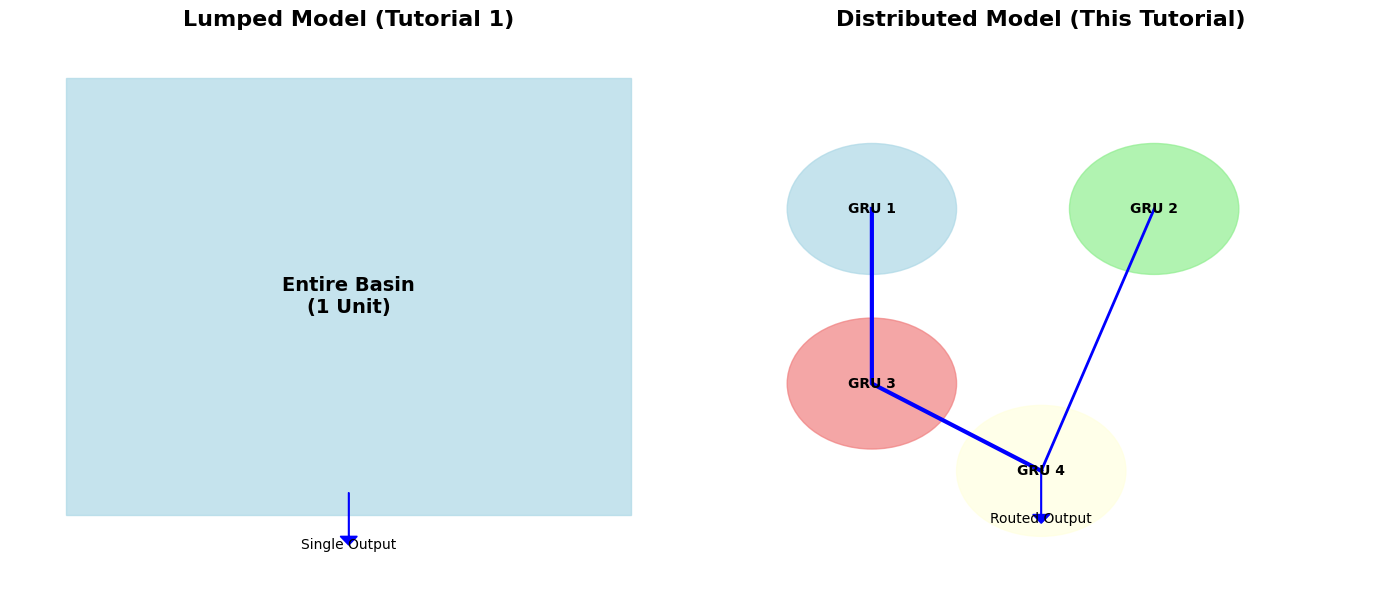

In [4]:
# Create visualization comparing lumped vs distributed
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Lumped representation
ax1.add_patch(plt.Rectangle((0, 0), 1, 1, fill=True, color='lightblue', alpha=0.7))
ax1.text(0.5, 0.5, 'Entire Basin\n(1 Unit)', ha='center', va='center', fontsize=14, fontweight='bold')
ax1.arrow(0.5, 0.05, 0, -0.1, head_width=0.03, head_length=0.02, fc='blue', ec='blue')
ax1.text(0.5, -0.08, 'Single Output', ha='center', fontsize=10)
ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim(-0.15, 1.1)
ax1.set_title('Lumped Model (Tutorial 1)', fontsize=16, fontweight='bold')
ax1.axis('off')

# Distributed representation
# Create sub-basins with river network
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
positions = [(0.2, 0.7), (0.7, 0.7), (0.2, 0.3), (0.5, 0.1)]
labels = ['GRU 1', 'GRU 2', 'GRU 3', 'GRU 4']

for i, (pos, color, label) in enumerate(zip(positions, colors, labels)):
    circle = plt.Circle(pos, 0.15, fill=True, color=color, alpha=0.7, edgecolor='black')
    ax2.add_patch(circle)
    ax2.text(pos[0], pos[1], label, ha='center', va='center', fontsize=10, fontweight='bold')

# Draw river network
ax2.plot([0.2, 0.2, 0.5], [0.7, 0.3, 0.1], 'b-', linewidth=3)  # Main stem
ax2.plot([0.7, 0.5], [0.7, 0.1], 'b-', linewidth=2)  # Tributary
ax2.arrow(0.5, 0.1, 0, -0.1, head_width=0.03, head_length=0.02, fc='blue', ec='blue')
ax2.text(0.5, -0.02, 'Routed Output', ha='center', fontsize=10)

ax2.set_xlim(-0.1, 1.1)
ax2.set_ylim(-0.15, 1.1)
ax2.set_title('Distributed Model (This Tutorial)', fontsize=16, fontweight='bold')
ax2.axis('off')

plt.tight_layout()
plt.show()

## 5. Step 1: Setup Project Structure

In [5]:
# Setup project directories
print("Creating project directory structure for distributed model...")
confluence.setup_project()

# List created directories
print("\nCreated directories:")
for item in sorted(confluence.project_dir.iterdir()):
    if item.is_dir():
        print(f"  📁 {item.name}")

2025-05-10 17:14:17,767 - confluence_general - INFO - Setting up project for domain: Bow_at_Banff_distributed
2025-05-10 17:14:17,774 - confluence_general - INFO - Project directory created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed
2025-05-10 17:14:17,776 - confluence_general - INFO - shapefiles directories created


Creating project directory structure for distributed model...

Created directories:
  📁 _workLog_Bow_at_Banff_distributed
  📁 attributes
  📁 documentation
  📁 evaluation
  📁 observations
  📁 shapefiles
  📁 taudem-interim-files


## 6. Step 2: Create Pour Point (Same as Lumped)

In [6]:
# Create pour point shapefile - same location as lumped model
print(f"Creating pour point shapefile from coordinates: {confluence.config['POUR_POINT_COORDS']}")
confluence.create_pourPoint()

# The pour point is the same as the lumped model
print("\nNote: The pour point location is identical to the lumped model.")
print("The difference is in how we subdivide the watershed above this point.")

Creating pour point shapefile from coordinates: 51.1722/-115.5717


2025-05-10 17:14:20,315 - pyogrio._io - INFO - Created 1 records
2025-05-10 17:14:20,318 - confluence_general - INFO - Pour point shapefile created successfully: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/pour_point/Bow_at_Banff_distributed_pourPoint.shp



Note: The pour point location is identical to the lumped model.
The difference is in how we subdivide the watershed above this point.


## 7. Step 3: Acquire Geospatial Attributes

In [7]:
# Acquire DEM, soil classes, and land cover
print("Acquiring geospatial attributes...")
print("These are the same data sources as the lumped model.")

confluence.acquire_attributes()

print("\n✓ Geospatial attributes acquired")

Acquiring geospatial attributes...
These are the same data sources as the lumped model.
(2025-05-10 23:11:12) merit_hydro.sh: processing MERIT-Hydro GeoTIFF(s)...
(2025-05-10 23:11:12) merit_hydro.sh: creating cache directory under /home/darri.eythorsson/cache_Bow_at_Banff_distributed
(2025-05-10 23:11:12) merit_hydro.sh: creating output directory under /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/attributes/elevation/dem
(2025-05-10 23:11:12) merit_hydro.sh: untarring MERIT-Hydro variables under /home/darri.eythorsson/cache_Bow_at_Banff_distributed
(2025-05-10 23:12:28) merit_hydro.sh: subsetting GeoTIFFs under /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/attributes/elevation/dem


mkdir: cannot create directory ‘/home/darri.eythorsson/empty_dir’: File exists


(2025-05-10 23:12:29) merit_hydro.sh: deleting temporary files from /home/darri.eythorsson/cache_Bow_at_Banff_distributed


2025-05-10 17:12:29,875 - confluence_general - INFO - gistool completed successfully.
2025-05-10 17:12:29,876 - confluence_general - INFO - Geospatial data acquisition process completed


(2025-05-10 23:12:29) merit_hydro.sh: temporary files from /home/darri.eythorsson/cache_Bow_at_Banff_distributed are removed
(2025-05-10 23:12:29) merit_hydro.sh: results are produced under /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/attributes/elevation/dem
(2025-05-10 23:12:33) modis.sh: processing MODIS HDF(s)...
(2025-05-10 23:12:33) modis.sh: creating cache directory under /home/darri.eythorsson/cache_Bow_at_Banff_distributed
(2025-05-10 23:12:33) modis.sh: creating output directory under /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/attributes/landclass
(2025-05-10 23:12:33) modis.sh: building virtual format (.vrt) of MODIS HDFs under /home/darri.eythorsson/cache_Bow_at_Banff_distributed


ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PRO

KeyboardInterrupt: 

## 8. Step 4: Delineate Distributed Domain

This is where the main difference occurs - we'll create multiple sub-basins instead of one lumped basin.

In [7]:
# Delineate the watershed with stream network
print(f"Delineating distributed watershed...")
print(f"Method: {confluence.config['DOMAIN_DEFINITION_METHOD']}")
print(f"Stream threshold: {confluence.config['STREAM_THRESHOLD']}")
print("\nThis will create multiple sub-basins connected by a stream network.")

confluence.define_domain()

# Check outputs
basin_path = confluence.project_dir / 'shapefiles' / 'river_basins'
network_path = confluence.project_dir / 'shapefiles' / 'river_network'

if basin_path.exists():
    basin_files = list(basin_path.glob('*.shp'))
    print(f"\n✓ Created basin shapefiles: {len(basin_files)}")
    
if network_path.exists():
    network_files = list(network_path.glob('*.shp'))
    print(f"✓ Created river network shapefiles: {len(network_files)}")
    
    # Load and check number of basins
    if basin_files:
        gdf = gpd.read_file(basin_files[0])
        print(f"\nNumber of sub-basins (GRUs): {len(gdf)}")
        print(f"Total area: {gdf.geometry.area.sum() / 1e6:.2f} km²")

2025-05-10 17:14:24,715 - confluence_general - INFO - Starting geofabric delineation
2025-05-10 17:14:24,717 - confluence_general - INFO - Geofabric delineation completed successfully
2025-05-10 17:14:24,720 - confluence_general - INFO - Starting geofabric delineation for Bow_at_Banff_distributed
2025-05-10 17:14:24,722 - confluence_general - INFO - Created interim directory: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8
2025-05-10 17:14:24,725 - confluence_general - INFO - Running command: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/pitremove -z /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/attributes/elevation/dem/domain_Bow_at_Banff_distributed_elv.tif -fel /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fel.tif -v


Delineating distributed watershed...
Method: delineate
Stream threshold: 5000

This will create multiple sub-basins connected by a stream network.


2025-05-10 17:14:26,193 - confluence_general - INFO - Command output: On input demfile: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/attributes/elevation/dem/domain_Bow_at_Banff_distributed_elv.tif
On input newfile: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fel.tif
Not Using mask file: N/A
PitRemove version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/attributes/elevation/dem/domain_Bow_at_Banff_distributed_elv.tif has geographic coordinate system.
Nodata value input to create partition from file: -9999.000000
Nodata value recast to float used in partition raster: -9999.000000
Header read
Process: 0, totalX: 1260, totalY: 972
Process: 0, nx: 1260, ny: 972
Process: 0, xstart: 0, ystart: 0
Data read
Midpoint of partition: 0, nxm: 630, nym: 486, value: 2002.900024
Planchon grid initialized rank: 0
Rank: 0, Stack size: 102
Rank: 0, Stack size: 100102
Rank: 0, Stack 


✓ Created basin shapefiles: 1
✓ Created river network shapefiles: 1

Number of sub-basins (GRUs): 49
Total area: 0.00 km²


/tmp/ipykernel_283846/3497950539.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(f"Total area: {gdf.geometry.area.sum() / 1e6:.2f} km²")


## 9. Visualize the Distributed Domain

2025-05-10 17:14:45,642 - confluence_general - INFO - Creating domain visualization...


Creating distributed domain visualization...


2025-05-10 17:14:46,738 - confluence_general - INFO - Domain map saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/plots/domain/domain_map.png
2025-05-10 17:14:46,739 - confluence_general - INFO - Domain visualization created: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/plots/domain/domain_map.png


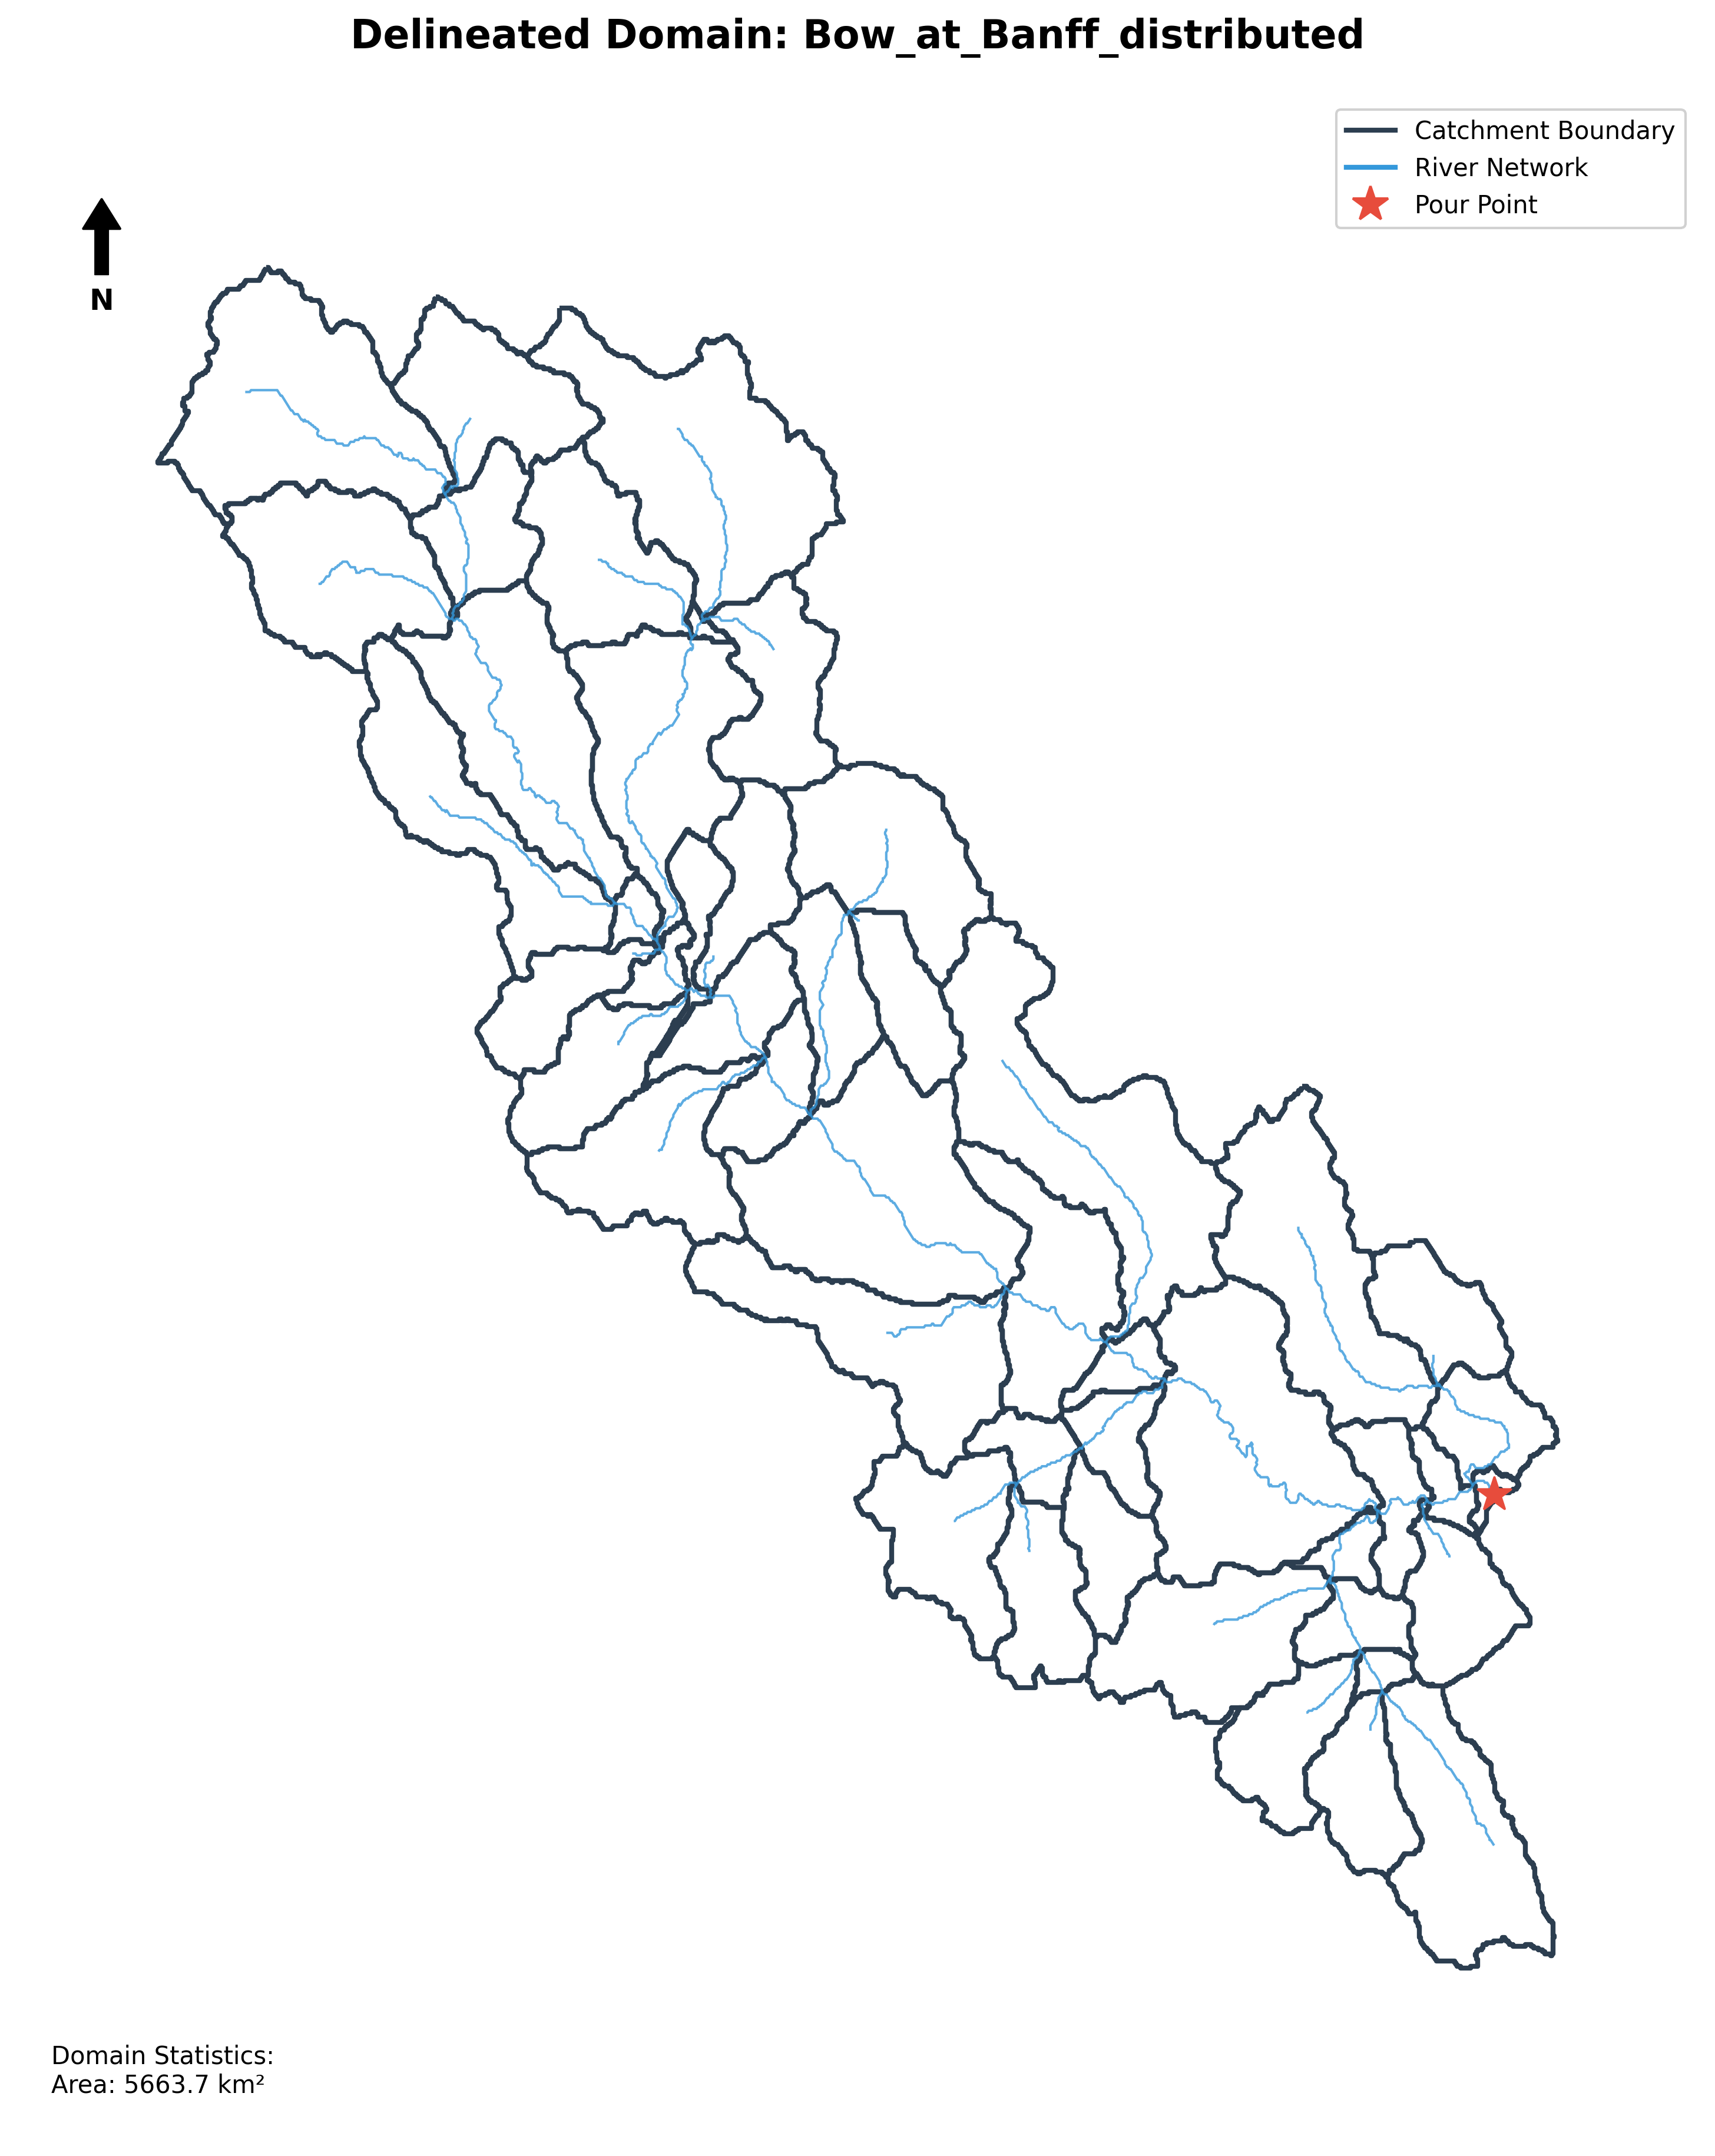

In [8]:
# Plot the distributed domain
print("Creating distributed domain visualization...")
confluence.plot_domain()

# Display the domain plot
plot_path = confluence.project_dir / 'plots' / 'domain' / 'domain_map.png'
if plot_path.exists():
    from IPython.display import Image, display
    display(Image(filename=str(plot_path)))
else:
    # Create custom visualization
    basin_files = list((confluence.project_dir / 'shapefiles' / 'river_basins').glob('*.shp'))
    network_files = list((confluence.project_dir / 'shapefiles' / 'river_network').glob('*.shp'))
    
    if basin_files and network_files:
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Load data
        basins = gpd.read_file(basin_files[0])
        rivers = gpd.read_file(network_files[0])
        
        # Plot basins with different colors
        basins.plot(ax=ax, column='GRU_ID', cmap='viridis', 
                   alpha=0.7, edgecolor='black', linewidth=0.5)
        
        # Plot river network
        rivers.plot(ax=ax, color='blue', linewidth=2)
        
        # Add pour point
        pour_point_path = confluence.project_dir / 'shapefiles' / 'pour_point' / f"{confluence.config['DOMAIN_NAME']}_pourPoint.shp"
        if pour_point_path.exists():
            pour_point = gpd.read_file(pour_point_path)
            pour_point.plot(ax=ax, color='red', markersize=150, marker='o', zorder=5)
        
        ax.set_title(f'Distributed Domain: {len(basins)} Sub-basins', fontsize=16, fontweight='bold')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        
        # Add colorbar for GRU IDs
        sm = plt.cm.ScalarMappable(cmap='viridis', 
                                   norm=plt.Normalize(vmin=basins['GRU_ID'].min(), 
                                                     vmax=basins['GRU_ID'].max()))
        sm._A = []
        cbar = fig.colorbar(sm, ax=ax, shrink=0.8)
        cbar.set_label('GRU ID', fontsize=12)
        
        plt.tight_layout()
        plt.show()

## 10. Step 5: Create GRU-based HRUs

In [9]:
# Create HRUs based on GRUs (1 GRU = 1 HRU)
print(f"Creating HRUs based on GRUs...")
print(f"Method: {confluence.config['DOMAIN_DISCRETIZATION']}")
print("For this tutorial: 1 GRU = 1 HRU (simplest case)")

confluence.discretize_domain()

# Check the created HRU shapefile
hru_path = confluence.project_dir / 'shapefiles' / 'catchment'
if hru_path.exists():
    hru_files = list(hru_path.glob('*.shp'))
    print(f"\n✓ Created HRU shapefiles: {len(hru_files)}")
    
    if hru_files:
        hru_gdf = gpd.read_file(hru_files[0])
        print(f"\nHRU Statistics:")
        print(f"Number of HRUs: {len(hru_gdf)}")
        print(f"Number of GRUs: {hru_gdf['GRU_ID'].nunique()}")
        print(f"Total area: {hru_gdf.geometry.area.sum() / 1e6:.2f} km²")
        
        # Show HRU distribution
        hru_counts = hru_gdf['GRU_ID'].value_counts()
        print(f"\nHRUs per GRU:")
        for gru_id, count in hru_counts.items():
            print(f"  GRU {gru_id}: {count} HRUs")

2025-05-10 17:14:51,114 - confluence_general - INFO - Discretizing domain using method: GRUs
2025-05-10 17:14:51,115 - confluence_general - INFO - Starting domain discretization using method: grus
2025-05-10 17:14:51,117 - confluence_general - INFO - Step 1/2: Running discretization method
2025-05-10 17:14:51,119 - confluence_general - INFO - config domain name Bow_at_Banff_distributed
2025-05-10 17:14:51,131 - confluence_general - INFO - Calculating mean elevation for each HRU


Creating HRUs based on GRUs...
Method: GRUs
For this tutorial: 1 GRU = 1 HRU (simplest case)


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(
/home/darri.eythorsson/code/CONFLUENCE/utils/geospatial_utils/discretization_utils.py:207: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_utm = gru_gdf.geometry.centroid
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feat


✓ Created HRU shapefiles: 1

HRU Statistics:
Number of HRUs: 49
Number of GRUs: 49
Total area: 0.00 km²

HRUs per GRU:
  GRU 8: 1 HRUs
  GRU 72: 1 HRUs
  GRU 82: 1 HRUs
  GRU 83: 1 HRUs
  GRU 86: 1 HRUs
  GRU 87: 1 HRUs
  GRU 88: 1 HRUs
  GRU 92: 1 HRUs
  GRU 94: 1 HRUs
  GRU 97: 1 HRUs
  GRU 102: 1 HRUs
  GRU 110: 1 HRUs
  GRU 111: 1 HRUs
  GRU 113: 1 HRUs
  GRU 114: 1 HRUs
  GRU 115: 1 HRUs
  GRU 116: 1 HRUs
  GRU 117: 1 HRUs
  GRU 118: 1 HRUs
  GRU 119: 1 HRUs
  GRU 120: 1 HRUs
  GRU 121: 1 HRUs
  GRU 122: 1 HRUs
  GRU 74: 1 HRUs
  GRU 67: 1 HRUs
  GRU 9: 1 HRUs
  GRU 62: 1 HRUs
  GRU 10: 1 HRUs
  GRU 14: 1 HRUs
  GRU 15: 1 HRUs
  GRU 18: 1 HRUs
  GRU 24: 1 HRUs
  GRU 27: 1 HRUs
  GRU 29: 1 HRUs
  GRU 32: 1 HRUs
  GRU 33: 1 HRUs
  GRU 38: 1 HRUs
  GRU 39: 1 HRUs
  GRU 41: 1 HRUs
  GRU 43: 1 HRUs
  GRU 46: 1 HRUs
  GRU 48: 1 HRUs
  GRU 52: 1 HRUs
  GRU 53: 1 HRUs
  GRU 55: 1 HRUs
  GRU 56: 1 HRUs
  GRU 58: 1 HRUs
  GRU 60: 1 HRUs
  GRU 123: 1 HRUs


/tmp/ipykernel_283846/1402975822.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(f"Total area: {hru_gdf.geometry.area.sum() / 1e6:.2f} km²")


## 11. Remaining Steps (Same as Lumped)

The remaining workflow steps are similar to the lumped model, but CONFLUENCE handles the multiple GRUs automatically.

In [ ]:
# Process observed data
print("Step 6: Processing observed streamflow data...")
confluence.process_observed_data()
print("✓ Observed data processed\n")

# Acquire forcing data
print("Step 7: Acquiring forcing data...")
confluence.acquire_forcings()
print("✓ Forcing data acquired\n")

# Model-agnostic preprocessing
print("Step 8: Running model-agnostic preprocessing...")
confluence.model_agnostic_pre_processing()
print("✓ Preprocessing completed\n")

# Model-specific preprocessing
print("Step 9: Preparing model input files...")
confluence.model_specific_pre_processing()
print("✓ Model inputs prepared")

2025-05-10 17:15:03,296 - confluence_general - INFO - Processing observed data
2025-05-10 17:15:03,298 - confluence_general - INFO - Processing WSC streamflow data from HYDAT database
2025-05-10 17:15:03,301 - confluence_general - INFO - Querying data from year 2018 to 2025
2025-05-10 17:15:03,302 - confluence_general - INFO - Retrieving discharge data for WSC station 05BB001 from HYDAT database
2025-05-10 17:15:03,303 - confluence_general - INFO - Database path: /work/comphyd_lab/data/geospatial-data/hydat/Hydat.sqlite3
2025-05-10 17:15:03,304 - confluence_general - INFO - Time period: 2018 to 2025
2025-05-10 17:15:03,327 - confluence_general - INFO - Found station 05BB001 in HYDAT database
2025-05-10 17:15:03,329 - confluence_general - INFO - Station name: BOW RIVER AT BANFF
2025-05-10 17:15:03,330 - confluence_general - INFO - Executing SQL query for daily flows...
2025-05-10 17:15:03,358 - confluence_general - INFO - Retrieved 72 monthly records from HYDAT
2025-05-10 17:15:03,440 -

Step 6: Processing observed streamflow data...


2025-05-10 17:15:04,326 - confluence_general - INFO - Processed streamflow data saved to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/observations/streamflow/preprocessed/Bow_at_Banff_distributed_streamflow_processed.csv
2025-05-10 17:15:04,328 - confluence_general - INFO - Total rows in processed data: 52561
2025-05-10 17:15:04,329 - confluence_general - INFO - Number of non-null values: 52561
2025-05-10 17:15:04,330 - confluence_general - INFO - Number of null values: 0
2025-05-10 17:15:04,336 - confluence_general - INFO - Successfully processed WSC data for station 05BB001
2025-05-10 17:15:04,338 - confluence_general - INFO - Observed data processing completed successfully


✓ Observed data processed

Step 7: Acquiring forcing data...


2025-05-10 17:15:07,810 - confluence_general - INFO - datatool job submitted successfully.


## 12. Run the Distributed Model

In [ ]:
# Run the model
print(f"Running distributed {confluence.config['HYDROLOGICAL_MODEL']} model...")
print(f"Number of GRUs: (check from previous output)")
print("Note: This will take longer than the lumped model due to multiple units.")

confluence.run_models()

print("\n✓ Model execution completed")

## 13. Visualize Distributed Results

In [ ]:
# Create visualization
print("Creating distributed model visualization...")
confluence.visualise_model_output()

# Display results
plot_path = confluence.project_dir / 'plots' / 'results' / 'streamflow_comparison.png'
if plot_path.exists():
    from IPython.display import Image, display
    display(Image(filename=str(plot_path)))
    
    print("\nNote: The streamflow output is from the basin outlet (routed through all GRUs).")

## 14. Compare Distributed vs Lumped Structure

Let's create a visual comparison of the domain structures.

In [ ]:
# Create comparison visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Lumped model visualization (if exists)
lumped_basin_path = confluence.data_dir / 'domain_Bow_at_Banff_lumped' / 'shapefiles' / 'river_basins'
if lumped_basin_path.exists():
    lumped_files = list(lumped_basin_path.glob('*.shp'))
    if lumped_files:
        lumped_basin = gpd.read_file(lumped_files[0])
        lumped_basin.plot(ax=ax1, color='lightblue', edgecolor='navy', linewidth=2)
        ax1.set_title('Lumped Model\n(1 Unit)', fontsize=14, fontweight='bold')
        ax1.axis('off')

# Distributed model visualization
dist_basin_path = confluence.project_dir / 'shapefiles' / 'river_basins'
dist_network_path = confluence.project_dir / 'shapefiles' / 'river_network'

if dist_basin_path.exists() and dist_network_path.exists():
    dist_basin_files = list(dist_basin_path.glob('*.shp'))
    dist_network_files = list(dist_network_path.glob('*.shp'))
    
    if dist_basin_files and dist_network_files:
        basins = gpd.read_file(dist_basin_files[0])
        network = gpd.read_file(dist_network_files[0])
        
        basins.plot(ax=ax2, column='GRU_ID', cmap='viridis', 
                   edgecolor='black', linewidth=0.5, alpha=0.7)
        network.plot(ax=ax2, color='blue', linewidth=2)
        ax2.set_title(f'Distributed Model\n({len(basins)} GRUs)', fontsize=14, fontweight='bold')
        ax2.axis('off')

plt.suptitle('Lumped vs Distributed Domain Structure', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 15. Summary and Key Differences

### What we accomplished:
1. Created a distributed model with multiple GRUs
2. Used stream network delineation
3. Maintained 1:1 relationship between GRUs and HRUs
4. Ran the same model (SUMMA) in distributed mode

### Key differences from lumped model:
- **Multiple spatial units**: Several GRUs instead of one
- **River routing**: mizuRoute connects the GRUs
- **More detailed representation**: Captures spatial variability
- **Longer computation time**: More units to simulate

### Next steps:
1. Compare performance metrics between lumped and distributed
2. Experiment with different stream thresholds
3. Try different discretization methods (elevation bands, land cover)
4. Calibrate parameters for individual GRUs

In [ ]:
# Print final summary
print("=== Distributed Workflow Complete ===\n")
print(f"Project: {confluence.config['DOMAIN_NAME']}")
print(f"Method: {confluence.config['DOMAIN_DEFINITION_METHOD']}")
print(f"Stream Threshold: {confluence.config['STREAM_THRESHOLD']}")
print(f"Model: {confluence.config['HYDROLOGICAL_MODEL']}")
print(f"\nKey outputs:")
print(f"  - Basin shapefile: shapefiles/river_basins/")
print(f"  - River network: shapefiles/river_network/")
print(f"  - Model results: simulations/{confluence.config['EXPERIMENT_ID']}/")
print(f"  - Comparison plots: plots/results/")